In [1]:
import awkward as ak
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
import hist
import os
from pprint import pprint 
from glob import glob
hep.style.use(hep.style.ROOT)

from coffea import processor
from coffea.util import load
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.processor import column_accumulator

import vector
vector.register_awkward()


In [3]:
output_folder = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/RecoPlots/DataPlots/Zee_Run2018D/"
input_folder_must = "/eos/user/r/rdfexp/ecal/cluster/raw_files/EGamma/Dumper_Mustache_bugFix/220919_211119"
input_folder_deep = "/eos/user/r/rdfexp/ecal/cluster/raw_files/EGamma/Dumper_DeepSC_algoA_bugFix/220919_211359"

fileset = {
    "DeepSC": glob(input_folder_deep+"/*/*.root", recursive=True)[0:20],
    "Mustache": glob(input_folder_must+"/*/*.root", recursive=True)[0:20]
}

In [16]:
patEle_fields = list(map( lambda k: k.strip().replace("patElectron_",""),
                         open("patElectron_fields.txt").readlines()))

In [15]:
patEle_fields

NameError: name 'patEle_fields' is not defined

In [ ]:

class ZeeProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        vector.register_awkward()
        electrons = ak.zip({k:events["patElectron_" + k] for k in patEle_fields},
                           with_name="Momentum4D")
        
        nele_init = ak.num(electrons, axis=1)
        
        id_mask = (electrons.egmCutBasedElectronIDloose==1)
        # Trying to replicate the skim selection
        #https://cmssdt.cern.ch/lxr/source/DPGAnalysis/Skims/python/ZElectronSkim_cff.py
#         mask_skim = (electrons.pt >= 10) &\
#                     ( ((abs(electrons.eta)<=1.4442) &(\
#                         (electrons.full5x5_refinedSCSigmaIEtaIEta < 0.0128)&\
#                         (electrons.deltaEtaIn < 0.00523)&\
#                         (electrons.deltaPhiIn < 0.159)&\
#                         (electrons.HoE < 0.247)&\
#                         (electrons.misHits<2)\
#                         ))|
#                         ((abs(electrons.eta)>=1.4442)&(abs(electrons.eta)<=2.5)&\
#                          (electrons.full5x5_refinedSCSigmaIEtaIEta < 0.0445)&\
#                          (electrons.deltaEtaIn < 0.00984)&\
#                          (electrons.deltaPhiIn < 0.157)&\
#                          (electrons.HoE < 0.0982)&\
#                          (electrons.misHits<3)
#                         )
#                     )
        
        # The only missing cuts
        #relCombIsolationWithEACut      = cms.vdouble(0.168  ,0.185  )  , # relCombIsolationWithEALowPtCut
        #EInverseMinusPInverseCut       = cms.vdouble(0.193  ,0.0962   )  ,                
        
        electrons = electrons[id_mask]
        nele_clean = ak.num(electrons, axis=1)
        # Ask for at least two remaining electrons
        electrons = electrons[ak.num(electrons, axis=1)>=2]
        lead_ele = electrons[:, 0]
        sublead_ele = electrons[:,1]
        Z =  lead_ele + sublead_ele
        # Cleaning the event asking for at lead Z.mass 40, leading 20 and sublead 10
        event_mask = (Z.mass>40.)&(lead_ele.pt >= 20.)&(sublead_ele.pt >= 10.)
        
        electrons = electrons[event_mask]
        Z = Z[event_mask]
        lead_ele = lead_ele[event_mask]
        sublead_ele = sublead_ele[event_mask]
        events = events[event_mask]
        
          
        efficiency_hist = hist.new.Integer(start=0, stop=10, name="nele_initial",label="N. ele initial")\
                                  .Integer(start=0, stop=10, name="nele_clean", label="N. ele cleaned")\
                                  .Double().fill(nele_init, nele_clean)
        
        
        hist_leading_ele = hist.new.Reg(name="et", label="Leading electron $E_T$",
                                       bins=50, start=0, stop=200,)\
                            .Var([0, 0.5, 1, 1.4442, 1.566, 2., 2.5],name="eta", 
                                 label="Leading electron $\eta$")\
                            .Integer(start=1, stop=15, name="ncls", label="Number of PF Clusters")\
                            .IntCategory([0,1,2,3,4], name="class",label="electron class")\
                            .Double()\
                            .fill(lead_ele.et, 
                                  abs(lead_ele.eta),
                                  lead_ele.nPFClusters,
                                  lead_ele.classification)
        
        hist_subleading_ele = hist.new.Reg(name="et", label="Subleading electron $E_T$",
                                       bins=50, start=0, stop=200)\
                            .Var([0, 0.5, 1, 1.4442, 1.566, 2., 2.5],name="eta", 
                                 label="Subleading electron $\eta$")\
                            .Integer(start=1, stop=15, name="ncls", label="Number of PF Clusters")\
                            .IntCategory([0,1,2,3,4], name="class",label="electron class")\
                            .Double()\
                            .fill(sublead_ele.et, 
                                  abs(sublead_ele.eta),
                                  sublead_ele.nPFClusters,
                                  sublead_ele.classification)
   

        hist_Z = hist.new.Reg(name="zmass", bins=120, start=60, stop=120, label="Zmass")\
                             .Reg(name="et", label="Leading electron $E_T$",
                                       bins=30, start=0, stop=200)\
                            .Var([0, 0.5, 1, 1.4442, 1.566, 2., 2.5],name="eta", 
                                 label="Leading electron $\eta$")\
                            .Integer(start=1, stop=15, name="ncls", label="Number of PF Clusters")\
                            .Reg(name="rho", start=0, stop=70, bins=30, label="$\rho$")\
                            .IntCategory([0,1,2,3,4], name="class",label="electron class")\
                            .Double()\
                            .fill(Z.mass,
                                  lead_ele.et,
                                  abs(lead_ele.eta),
                                  lead_ele.nPFClusters,
                                  events.rho,
                                  lead_ele.classification)
        
        return {
            dataset: {
                "entries": len(events),
                "histos": {
                    "Z": hist_Z,
                    "nele_eff": efficiency_hist,
                    "ele_lead": hist_leading_ele,
                    "ele_sublead": hist_subleading_ele
                },
                "Z": {
                    "mass": column_accumulator(ak.to_numpy(Z.mass)),
                    "ele_et": column_accumulator(ak.to_numpy(lead_ele.et)),
                    "ele_eta": column_accumulator(ak.to_numpy(lead_ele.eta)),
                    "ele_class": column_accumulator(ak.to_numpy(lead_ele.classification)),
                    "rho":column_accumulator(ak.to_numpy(events.rho)),
                    "nvtx":column_accumulator(ak.to_numpy(events.nVtx)),
                    "r9": column_accumulator(ak.to_numpy(lead_ele.full5x5_refinedSCR9))
                }       
            }
        }

    def postprocess(self, accumulator):
        pass


In [17]:
iterative_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=4),
    schema=BaseSchema,
    maxchunks=10,
    
)

out = iterative_run(
    fileset,
    treename="recosimdumper/caloTree",
    processor_instance=ZeeProcessor(),
)
out

Processing:   0%|          | 0/20 [00:00<?, ?chunk/s]

{'Mustache': {'Z': {'ele_class': column_accumulator(array([0, 1, 3, ..., 0, 3, 0], dtype=int32)),
   'ele_et': column_accumulator(array([50.829174, 43.697914, 31.751547, ..., 52.408344, 35.444435,
          46.58514 ], dtype=float32)),
   'ele_eta': column_accumulator(array([-2.029461  , -1.791851  ,  0.13757126, ..., -0.49773943,
           1.0391172 , -0.39091   ], dtype=float32)),
   'mass': column_accumulator(array([232.99066 , 303.52634 ,  49.526943, ...,  89.138916,  85.46639 ,
           90.830605], dtype=float32))},
  'entries': 4605,
  'histos': {'Z': Hist(
     Regular(120, 60, 120, name='zmass', label='Zmass'),
     Regular(30, 0, 200, name='et', label='Leading electron $E_T$'),
     Variable([0, 0.5, 1, 1.4442, 1.566, 2, 2.5], name='eta', label='Leading electron $\\eta$'),
     Integer(1, 15, name='ncls', label='Number of PF Clusters'),
     IntCategory([0, 1, 2, 3, 4], name='class', label='electron class'),
     storage=Double()) # Sum: 2169.0 (2986.0 with flow),
   'ele_s

## Output analysis

In [32]:
def plot_comparison(dfB, dfA, var, label, bins, xrange, output_folder, 
                    ylog=False, wA=None, wB=None, flatten=False,density=False):
    
    fig = plt.figure(figsize=(10,11), dpi=72)
    gs = fig.add_gridspec(2,1, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)
    
    ax =  axs[0]
    axr =  axs[1]
    
    if flatten:
        dfA = ak.flatten(dfA)
        dfB = ak.flatten(dfB)
    
    B, binX, _ = ax.hist(dfB, bins=bins, range=xrange,  weights=wB,
                         label="Mustache", histtype="step", linewidth=2, density=density)
    A, binX, _ = ax.hist(dfA, bins=bins, range=xrange, weights=wA,
                         label="DeepSC", histtype="step", linewidth=2, density=density)
    
    if density:
        errA,_ = np.histogram(dfA, bins=bins, range=xrange, weights=wA)
        errB,_ = np.histogram(dfB, bins=bins, range=xrange, weights=wB)
    else:
        errA = np.sqrt(A)
        errB = np.sqrt(B)

    ax.legend()
    axr.set_xlabel(label)
    hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=ax)
    mmax = max([max(A), max(B)])
    if ylog:
        ax.set_ylim(max([min(A), min(B),1e-3]), mmax*500)
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, mmax*1.4)


    errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)

    ratio= np.where( (A>0)&(B>0),
                     A/B,
                     1.) 
    
    centers = (np.roll(binX, -1) + binX)/2
 
    axr.errorbar(centers[:-1], ratio, xerr=0, yerr=errR,
                                fmt=".", linestyle='none', elinewidth=1, c="black")

    deltaMax = np.max(ratio)
    deltaMin = np.min(ratio)

    #print(deltaM)
    axr.set_ylim(max(0, deltaMin*0.8), deltaMax*1.2)
    axr.set_ylabel("D/M")
    axr.grid(which="both",axis="y")
    axr.plot([binX[0], binX[-1]], [1.,1.], linewidth=2, c="black")

    if output_folder!=None:
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + f"/{var}_comparison.png")
        fig.savefig(output_folder + f"/{var}_comparison.pdf")
        fig.savefig(output_folder + f"/{var}_comparison.svg")
    


In [33]:
out = load("output.coffea")

In [27]:
output_folder = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/RecoPlots/DataPlots/Zee_Run2018D/"

In [34]:
Zd = pd.DataFrame({k:v.value for k,v in out["DeepSC"]["Z"].items()})
Zm = pd.DataFrame({k:v.value for k,v in out["Mustache"]["Z"].items()})

In [ ]:
Zd

/tmp/ipykernel_1025/563489615.py:38: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_1025/563489615.py:38: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_1025/563489615.py:38: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_1025/563489615.py:41: RuntimeWarning: invalid value encountered in true_divide
  A/B,


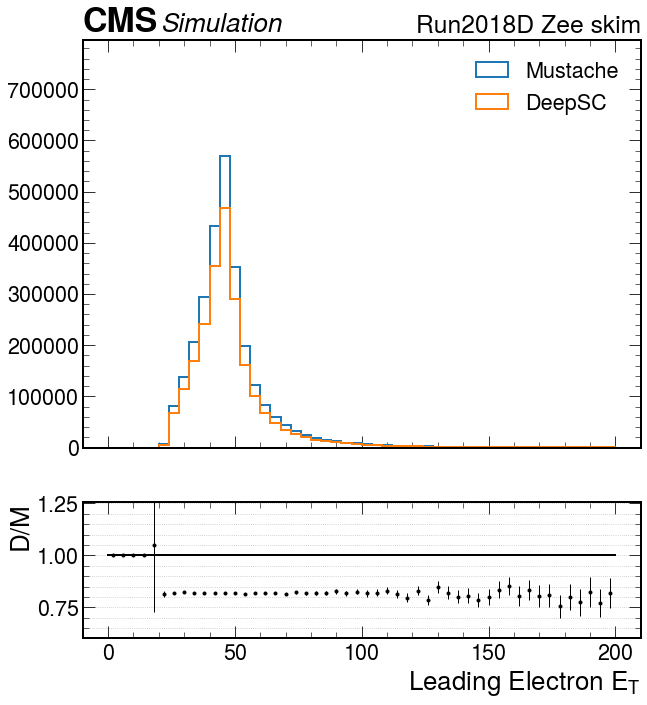

In [35]:
plot_comparison(Zm.ele_et, Zd.ele_et,
                label="Leading Electron $E_T$", var="lead_ele_pt_Zsel", 
                bins=50, xrange=(0,200),
                output_folder=output_folder)

# Efficiency study

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f16f77451c0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f16f7766d30>, text=[])

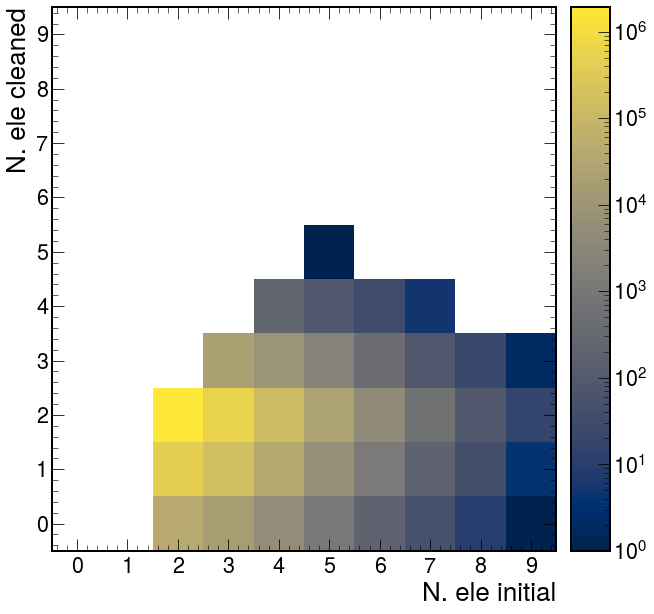

In [36]:
hep.hist2dplot(out["DeepSC"]["histos"]["nele_eff"], cmap="cividis", norm=LogNorm())

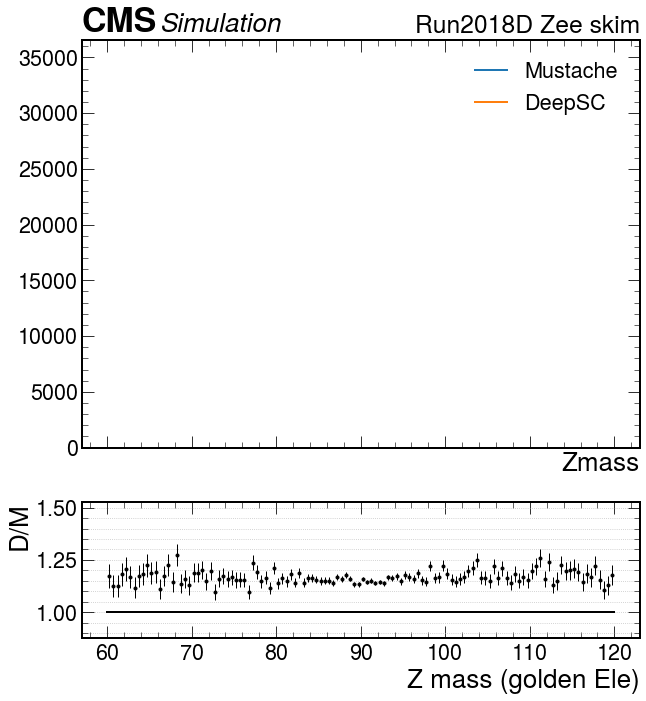

In [41]:
plot_comparison(out["Mustache"]["histos"]["Z"][{"class":0}].project("zmass"), 
                out["DeepSC"]["histos"]["Z"][{"class":0}].project("zmass"),
                label="Z mass (golden Ele)", var="Z_mass_golden", 
                )

In [48]:
hZm = out["Mustache"]["histos"]["Z"]
hZd = out["DeepSC"]["histos"]["Z"]

In [47]:
hZ

Hist(
  Regular(120, 60, 120, name='zmass', label='Zmass'),
  Regular(30, 0, 200, name='et', label='Leading electron $E_T$'),
  Variable([0, 0.5, 1, 1.4442, 1.566, 2, 2.5], name='eta', label='Leading electron $\\eta$'),
  Integer(1, 15, name='ncls', label='Number of PF Clusters'),
  IntCategory([0, 1, 2, 3, 4], name='class', label='electron class'),
  storage=Double()) # Sum: 2033228.0 (2757796.0 with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f5578314c40>, errorbar=None, legend_artist=None)]

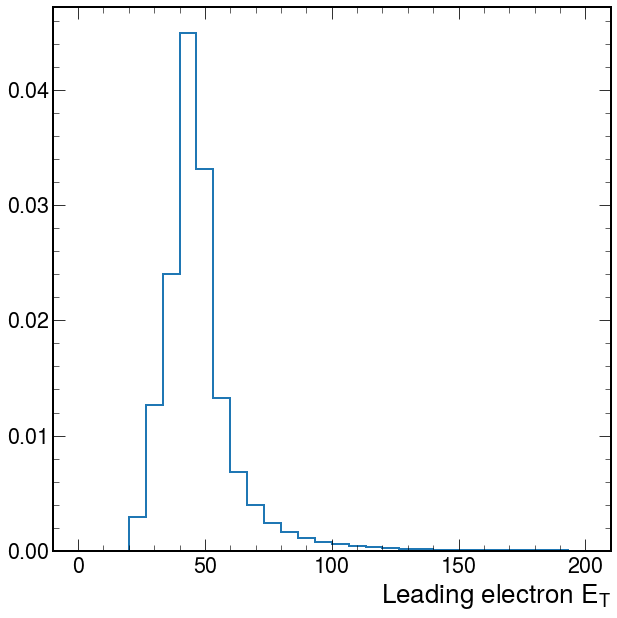

In [51]:
hep.histplot(hZm.project("et"), label="Mustache", histtype="step", linewidth=2,density=True)

In [14]:
hep.histplot(hZm[{"eta":slice(1j,2j),"et":slice(0,30j)}].project("zmass"), label="Mustache", histtype="step", linewidth=2,density=True)
hep.histplot(hZd[{"eta":slice(1j,2j),"et":slice(0,30j)}].project("zmass"), label="DeepSC", histtype="step", linewidth=2, density=True)
plt.legend()

NameError: name 'hZm' is not defined

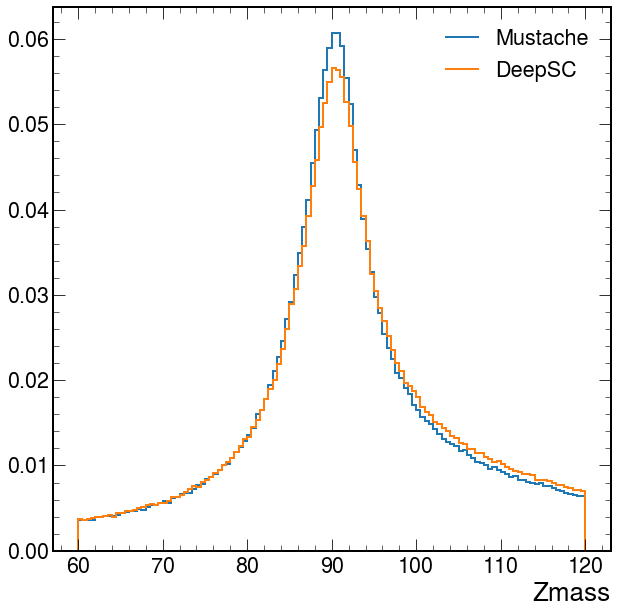

In [63]:
hep.histplot(hZm[{"eta":slice(1j,2j),"et":slice(0,30j), "class":3}].project("zmass"), label="Mustache", histtype="step", linewidth=2,density=True)
hep.histplot(hZd[{"eta":slice(1j,2j),"et":slice(0,30j), "class":3}].project("zmass"), label="DeepSC", histtype="step", linewidth=2, density=True)
plt.legend()

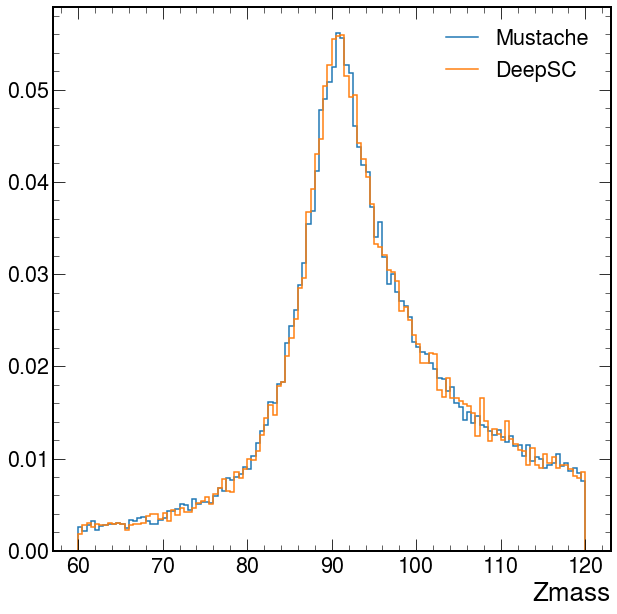

In [11]:



hep.histplot(out["Mustache"]["histos"]["Z"][{"class":2}].project("zmass"), label="Mustache", density=True)
hep.histplot(out["DeepSC"]["histos"]["Z"][{"class":2}].project("zmass"), label="DeepSC", density=True)
plt.legend()

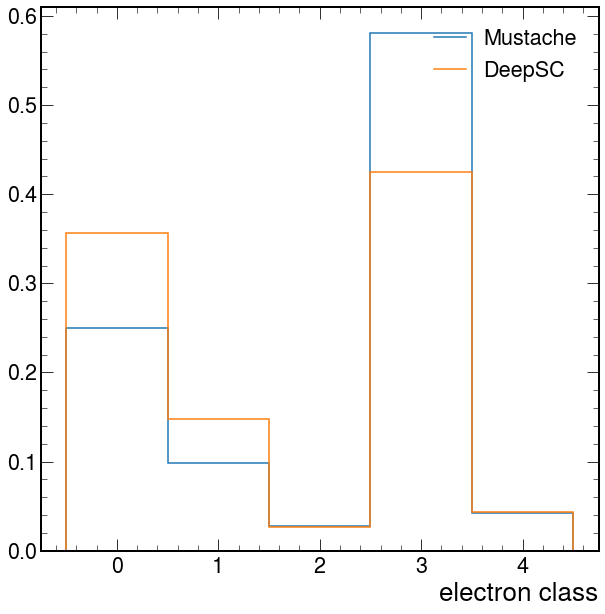

In [45]:
hep.histplot(out["Mustache"]["histos"]["ele_lead"].project("class"), label="Mustache",density=True)
hep.histplot(out["DeepSC"]["histos"]["ele_lead"].project("class"), label="DeepSC", density=True)
plt.legend()

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f948c318f40>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f948c312ee0>, text=[])

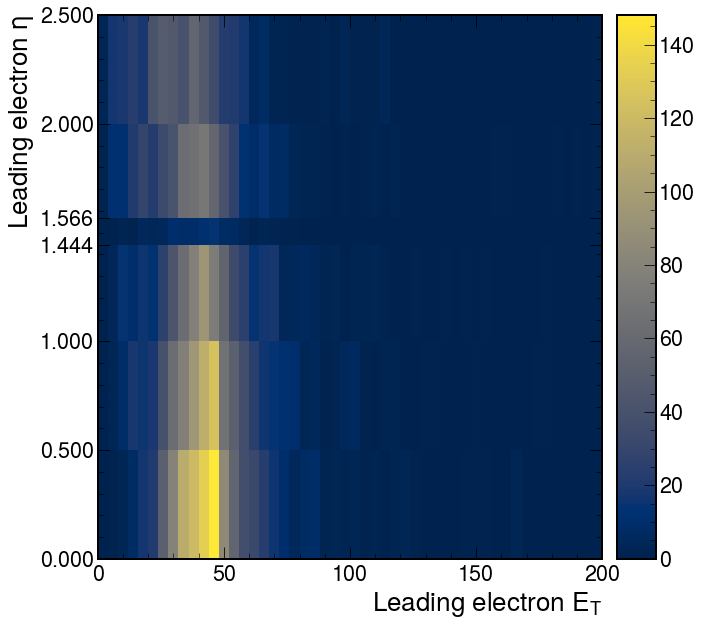

In [100]:
hep.hist2dplot(out["DeepSC"]["histos"]["ele_lead"][{"class":sum, "nPFCls":sum}], cmap="cividis")

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f948b722250>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f948c187eb0>, text=[])

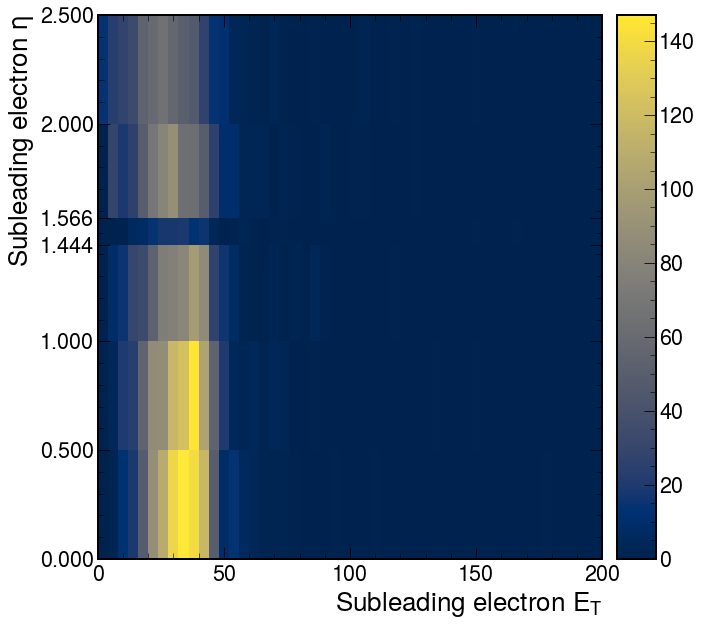

In [101]:
hep.hist2dplot(out["DeepSC"]["histos"]["ele_sublead"][{"class":sum, "nPFCls":sum}], cmap="cividis")

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f948f1911f0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f948f1b36a0>, text=[])

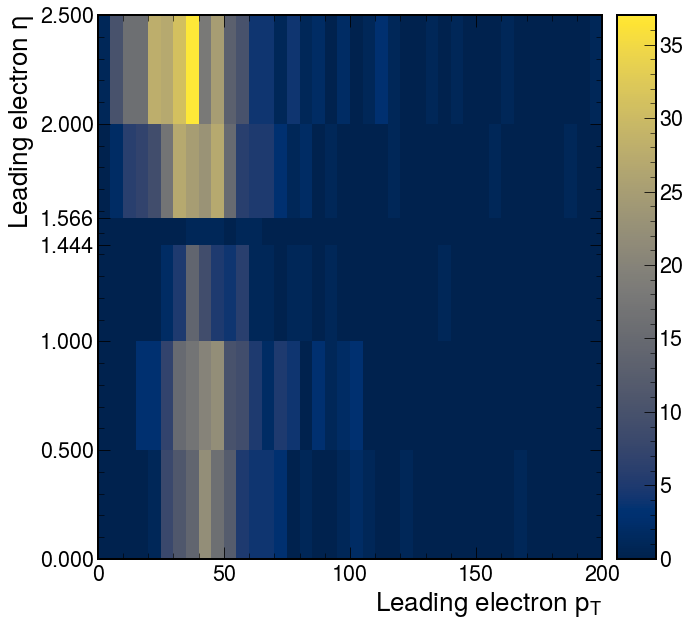

In [75]:
hep.hist2dplot(out["DeepSC"]["histos"]["ele_lead"][{"class":1, "nPFCls":sum}], cmap="cividis")

In [37]:
hep.hist2dplot(out["DeepSC"]["histos"]["ele_lead_pt"][{"class":4}])

KeyError: 'ele_lead_pt'

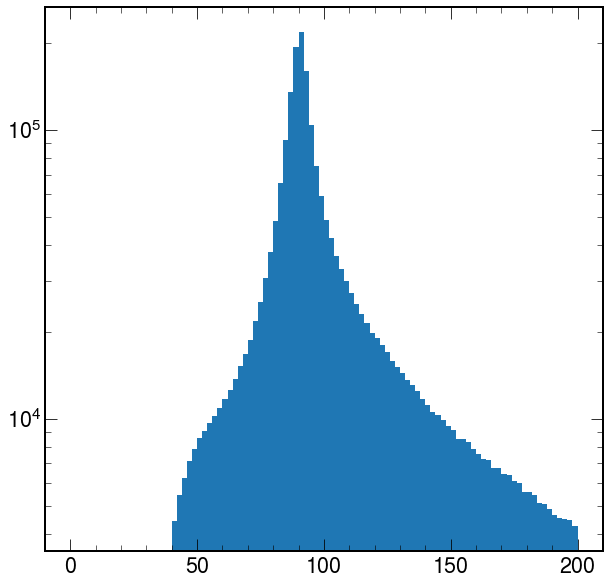

In [41]:
Zm = out["DeepSC"]["Z"]["mass"].value
plt.hist(Zm, bins=100, range=(0, 200))
plt.yscale("log")